#Taller 4: Neural Networks and Deep Learning Punto 2
#$Integrantes$:
>Juan Felipe Baquero Vargas

>Lina Fernanda Rosales Castro

In [1]:
caffe_root = '/opt/caffe/'
data_root = 'birds/'

In [2]:
%matplotlib inline
import os
import sys
import caffe
import numpy as np
import pylab as pl
import pandas as pd
import sklearn as skl
import matplotlib.pyplot as plt
from IPython.display import display, HTML, Math, Latex, clear_output

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 15 days


In [3]:
def getListOfFilesByExtension( path, ext):
    lstFiles = []
    #Lista con todos los ficheros del directorio:
    lstDir = os.walk(path) #os.walk()Lista directorios y ficheros
    
    for root, dirs, files in lstDir:
        for arch in files:
            (nameFile, extension) = os.path.splitext(arch)
            if extension == ext :
                lstFiles.append( root+"/"+arch )
    
    return lstFiles

def printImg( image, text=None ):
    plt.clf()
    if text!=None:
        plt.title( text )
    input_image = caffe.io.load_image( image )
    plt.imshow(input_image)
    plt.show()
    
def getImages( listDir ):
    listImg = [ caffe.io.load_image(img) for img in listDir ]
    return listImg



In [4]:
#Funcion que muestra tabla con cabecera
def printTable( sTable, msg, latex=1):
    if latex==1:
        display(Latex(msg))
    else:
        display(HTML('<center><b><font color="red">'+msg+'</font></b></center>') )
    
    display( sTable )

Configurando el entorno

Show floder whit caffe and Alexnet model

In [5]:
ls /opt/caffe/models/

bvlc_alexnet/    bvlc_reference_caffenet/       finetune_flickr_style/
bvlc_googlenet/  bvlc_reference_rcnn_ilsvrc13/


In [6]:
ls /opt/caffe/models/bvlc_alexnet/

deploy.prototxt  readme.md  solver.prototxt  train_val.prototxt


In [7]:
ls

birds/                   caffe_ilsvrc12/
birds.zip                glog-0.3.3.tar.gz
bvlc_alexnet.caffemodel  ml-assign4-jfbaquerov-lfrosalesc-Punto2.ipynb


Configuracion para contruir la red

In [5]:
listPathImg = getListOfFilesByExtension( data_root, ".jpg")
listImg = getImages( listPathImg )

In [9]:
listPathImg

['birds/wood_duck/wod036.jpg',
 'birds/wood_duck/wod035.jpg',
 'birds/wood_duck/wod048.jpg',
 'birds/wood_duck/wod051.jpg',
 'birds/wood_duck/wod082.jpg',
 'birds/wood_duck/wod049.jpg',
 'birds/wood_duck/wod092.jpg',
 'birds/wood_duck/wod056.jpg',
 'birds/wood_duck/wod022.jpg',
 'birds/wood_duck/wod061.jpg',
 'birds/wood_duck/wod055.jpg',
 'birds/wood_duck/wod010.jpg',
 'birds/wood_duck/wod095.jpg',
 'birds/wood_duck/wod046.jpg',
 'birds/wood_duck/wod069.jpg',
 'birds/wood_duck/wod054.jpg',
 'birds/wood_duck/wod097.jpg',
 'birds/wood_duck/wod027.jpg',
 'birds/wood_duck/wod050.jpg',
 'birds/wood_duck/wod029.jpg',
 'birds/wood_duck/wod059.jpg',
 'birds/wood_duck/wod039.jpg',
 'birds/wood_duck/wod084.jpg',
 'birds/wood_duck/wod044.jpg',
 'birds/wood_duck/wod093.jpg',
 'birds/wood_duck/wod012.jpg',
 'birds/wood_duck/wod043.jpg',
 'birds/wood_duck/wod013.jpg',
 'birds/wood_duck/wod007.jpg',
 'birds/wood_duck/wod042.jpg',
 'birds/wood_duck/wod031.jpg',
 'birds/wood_duck/wod073.jpg',
 'birds/

In [6]:
MODEL_FILE = caffe_root+'models/bvlc_alexnet/deploy.prototxt'
PRETRAINED = 'bvlc_alexnet.caffemodel'

####Using Caffe.Net

In [22]:
caffe.set_mode_gpu()
net = caffe.Net(MODEL_FILE,PRETRAINED,caffe.TEST)

# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
transformer.set_mean('data', np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1)) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

In [23]:
# set net to batch size of 600
nImages=600
net.blobs['data'].reshape(nImages,3,227,227)

In [24]:
# GPU mode
caffe.set_mode_gpu()
net.forward()  # call once for allocation
%timeit net.forward()


1 loops, best of 3: 228 ms per loop


In [21]:
#net.blobs['data'].data[...] = transformer.preprocess('data', caffe.io.load_image(caffe_root + 'examples/images/cat.jpg'))
#out = net.forward()
#print("Predicted class is #{}.".format(out['prob'][0].argmax()))

Predicted class is #285.


In [44]:
def predict_image( path ):
    return transformer.preprocess('data', caffe.io.load_image(path) )

pathToIdx = {}

def predict_images( paths ):
    prediction = []
    if len(paths) > net.blobs['data'].shape[0]:
        net.blobs['data'].reshape(len(paths),3,227,227)
        
    for idx, img in enumerate( paths ):
        net.blobs['data'].data[idx] = predict_image( img )
        pathToIdx[ img ] = idx
        prediction.append( np.copy(net.blobs['prob'].data[idx].flatten()) )
    return prediction;

def predict_images_layers( paths ):
    prediction = []
    fc6 = []
    fc7 = []
    #print "antes",len(paths)," -- ", net.blobs['data'].shape[0]
    if len(paths) > net.blobs['data'].shape[0]:
        net.blobs['data'].reshape(len(paths),3,227,227)
    #print "Despu",len(paths)," -- ", net.blobs['data'].shape[0]
    
    for idx, img in enumerate( paths ):
        net.blobs['data'].data[idx] = predict_image( img )
        prediction.append( np.copy(net.blobs['prob'].data[idx].flatten()) )
        fc6.append( np.copy(net.blobs['fc6'].data[idx]) )
        fc7.append( np.copy(net.blobs['fc7'].data[idx]) )
    out = net.forward()
    return prediction, fc6, fc7

####Using caffe.Classifier

In [16]:
# Set the right path to your model definition file, pretrained model weights,
# and the image you would like to classify.
#MODEL_FILE = caffe_root+'models/bvlc_alexnet/deploy.prototxt'
#PRETRAINED = 'bvlc_alexnet.caffemodel'
IMAGE_FILE = listImg[0]
caffe.set_mode_gpu()
net2 = caffe.Classifier(MODEL_FILE, PRETRAINED,
                       mean=np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1),
                       channel_swap=(2,1,0),
                       raw_scale=255,
                       image_dims=(256, 256) 
                       )

Ejemplo de las imagenes que trabajaremos

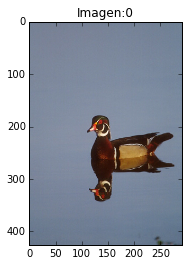

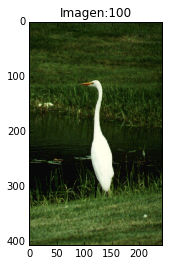

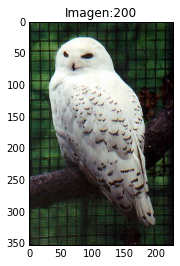

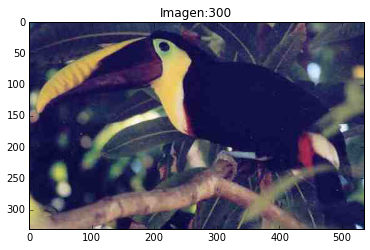

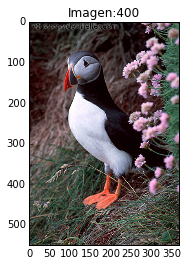

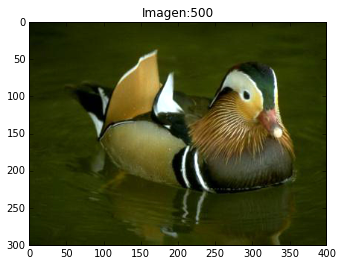

In [17]:
for i in xrange(0, len(listImg), 100):
    printImg(listPathImg[i], text="Imagen:"+str(i))

In [18]:
# GPU mode
caffe.set_device(0)
caffe.set_mode_gpu()
net2.forward()  # call once for allocation
%timeit net2.forward()


100 loops, best of 3: 6.3 ms per loop


### (B) classify the images in the birds dataset

In [12]:
# load labels
imagenet_labels_filename = 'caffe_ilsvrc12/synset_words.txt'
try:
    labels = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')
except:
    !../data/ilsvrc12/get_ilsvrc_aux.sh
    labels = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')


In [13]:
clase = ["wood_duck","egret","owl", "toucan", "puffin", "mandarin"]

####Using caffe.Net

In [45]:
prediction = predict_images( listPathImg )

In [46]:
out = net.forward()
%timeit net.forward()

1 loops, best of 3: 238 ms per loop


prediction shape: (1000,)
predicted class: 97 n01847000 drake


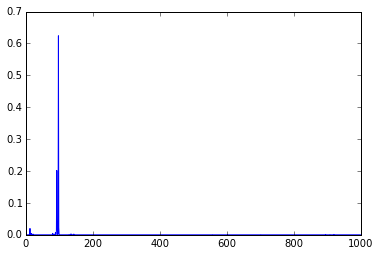

In [47]:
out['prob'].shape
print 'prediction shape:', out['prob'][0].shape
plt.plot(out['prob'][0])
print 'predicted class:', out['prob'][0].argmax(), labels[ out['prob'][0].argmax() ]
plt.show()

prediction shape: (1000,)
predicted class: 97 n01847000 drake


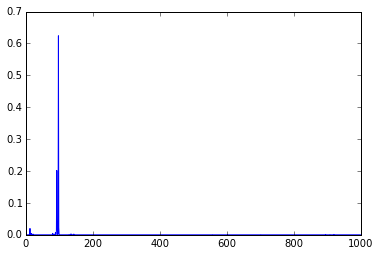

In [48]:
print 'prediction shape:', prediction[0].shape
plt.plot(prediction[0])
print 'predicted class:', prediction[0].argmax(), labels[ prediction[0].argmax() ]
plt.show()

In [49]:
freq = np.sum(prediction, axis=0)
most_freq = freq.argsort()[-1:-11:-1]
most_freq_freq = freq[ most_freq ]

indice = {}
for idx, frq in enumerate( most_freq ):
    indice[frq] = idx
    
toTable = zip( most_freq, most_freq_freq, labels[ most_freq ] )
table = pd.DataFrame( data=toTable, index=range(1,len(most_freq)+1), columns=["ClaseID", "Peso", "Clase"])
printTable( table, "10 Mejores Datos", latex=0)

,ClaseID,Peso,Clase
1,97,145.747009,n01847000 drake
2,96,101.953102,n01843383 toucan
3,132,73.698540,"n02009912 American egret, great white heron, E..."
4,81,17.499439,n01796340 ptarmigan
5,99,16.354301,n01855672 goose
6,143,13.301416,"n02037110 oystercatcher, oyster catcher"
7,129,11.770548,n02006656 spoonbill
8,21,10.405140,n01608432 kite
9,146,10.354755,"n02058221 albatross, mollymawk"
10,87,10.040297,"n01817953 African grey, African gray, Psittacu..."


In [42]:
freq = np.sum(out['prob'], axis=0)
most_freq = freq.argsort()[-1:-11:-1]
most_freq_freq = freq[ most_freq ]

indice = {}
for idx, frq in enumerate( most_freq ):
    indice[frq] = idx
    
toTable = zip( most_freq, most_freq_freq, labels[ most_freq ] )
table = pd.DataFrame( data=toTable, index=range(1,len(most_freq)+1), columns=["ClaseID", "Peso", "Clase"])
printTable( table, "10 Mejores Datos(out['prob'])", latex=0)

,ClaseID,Peso,Clase
1,97,145.747009,n01847000 drake
2,96,101.953102,n01843383 toucan
3,132,73.698540,"n02009912 American egret, great white heron, E..."
4,81,17.499439,n01796340 ptarmigan
5,99,16.354301,n01855672 goose
6,143,13.301416,"n02037110 oystercatcher, oyster catcher"
7,129,11.770548,n02006656 spoonbill
8,21,10.405140,n01608432 kite
9,146,10.354755,"n02058221 albatross, mollymawk"
10,87,10.040297,"n01817953 African grey, African gray, Psittacu..."


In [43]:
noIn = 10

confMatriz = np.zeros( (6, 11) )
idx = 0
for cnt, p in enumerate( prediction ):
    if( cnt!=0 and cnt%100==0 ):
        idx+=1; 
    #print cnt, p.argmax(), idx
    if p.argmax() in most_freq:
        confMatriz[idx][ indice[p.argmax()] ] +=1
    else:
        confMatriz[idx][ noIn ] +=1

col = [x for x in most_freq]
col.append('Otro')
table = pd.DataFrame(data=confMatriz, index=clase, columns=col)
printTable(table, "Matriz de Confusion para las 10 clases mas frecuentes", latex=0)
col = [labels[x] for x in most_freq]
col.append('Otro')
table = pd.DataFrame(data=confMatriz, index=clase, columns=col)
printTable(table, "Matriz de Confusion para las 10 clases mas frecuentes(Label)", latex=0)

,97,96,132,81,99,143,129,21,146,87,Otro
wood_duck,84,0,0,0,0,1,0,0,0,0,15
egret,0,0,84,0,0,0,8,0,1,0,7
owl,0,0,0,19,0,0,0,8,0,12,61
toucan,0,96,0,0,0,0,0,0,0,0,4
puffin,8,12,0,1,15,13,0,4,12,1,34
mandarin,72,0,0,0,1,1,1,0,0,0,25


,n01847000 drake,n01843383 toucan,"n02009912 American egret, great white heron, Egretta albus",n01796340 ptarmigan,n01855672 goose,"n02037110 oystercatcher, oyster catcher",n02006656 spoonbill,n01608432 kite,"n02058221 albatross, mollymawk","n01817953 African grey, African gray, Psittacus erithacus",Otro
wood_duck,84,0,0,0,0,1,0,0,0,0,15
egret,0,0,84,0,0,0,8,0,1,0,7
owl,0,0,0,19,0,0,0,8,0,12,61
toucan,0,96,0,0,0,0,0,0,0,0,4
puffin,8,12,0,1,15,13,0,4,12,1,34
mandarin,72,0,0,0,1,1,1,0,0,0,25


Para este prueba se utilizo la funcion Net de Caffe. La matriz de confusion muestra que las imagenes mejor clasificadas fueron las del tucan, por otro lado las imagenes de Buhos fueron asociadas a otros animales, la clase Buhos presenta buhos que por la descripcion de la clase se podria enterder que no fueron analisados (La clase es de buhos oscuros, en los ejemplos varios buhos fueron blancos). entonces estas imagenes fueron clasificadas en clases que nisiquiera eran aves (papel higienico, otros animales). En conclusion las aves que la red ya conocia fueron mejor clasificadas que las que no tenian una clase asociada en la red de pre entrenamiento, en las clases del data set birds, se hace diferencias entre varios sub tipos de animales, por ejemplo los patos, la red no es tan especifica y no discrimino entre diferentes tipos de patos.

####Using caffe.Clasifier

In [28]:
prediction = net2.predict( listImg )

prediction shape: (1000,)
predicted class: 97


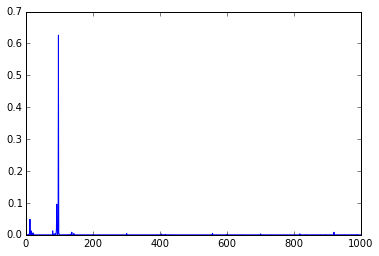

In [29]:
print 'prediction shape:', prediction[0].shape
plt.plot(prediction[0])
print 'predicted class:', prediction[0].argmax()
plt.show()

-----------------------------------------


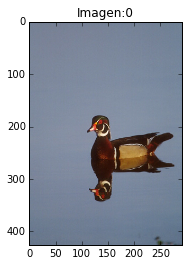

<IPython.core.display.Latex object>

,Prediccion
97,n01847000 drake
92,n01828970 bee eater
12,"n01532829 house finch, linnet, Carpodacus mexi..."
93,n01829413 hornbill
96,n01843383 toucan
91,n01824575 coucal
80,n01795545 black grouse
16,n01560419 bulbul
94,n01833805 hummingbird
11,"n01531178 goldfinch, Carduelis carduelis"


predicted class: 97


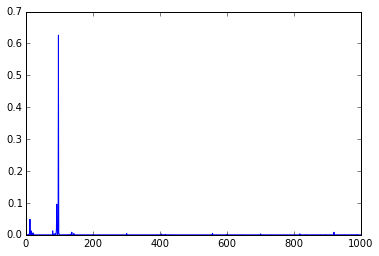

-----------------------------------------


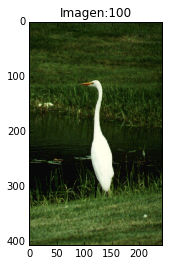

<IPython.core.display.Latex object>

,Prediccion
132,"n02009912 American egret, great white heron, E..."
134,n02012849 crane
146,"n02058221 albatross, mollymawk"
99,n01855672 goose
145,"n02056570 king penguin, Aptenodytes patagonica"
129,n02006656 spoonbill
144,n02051845 pelican
131,"n02009229 little blue heron, Egretta caerulea"
89,"n01819313 sulphur-crested cockatoo, Kakatoe ga..."
127,"n02002556 white stork, Ciconia ciconia"


predicted class: 132


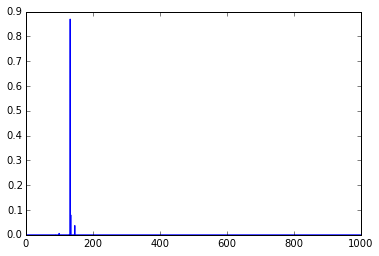

-----------------------------------------


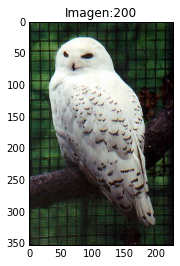

<IPython.core.display.Latex object>

,Prediccion
23,n01616318 vulture
21,n01608432 kite
89,"n01819313 sulphur-crested cockatoo, Kakatoe ga..."
22,"n01614925 bald eagle, American eagle, Haliaeet..."
24,"n01622779 great grey owl, great gray owl, Stri..."
251,"n02110341 dalmatian, coach dog, carriage dog"
212,n02100735 English setter
81,n01796340 ptarmigan
87,"n01817953 African grey, African gray, Psittacu..."
85,n01806567 quail


predicted class: 23


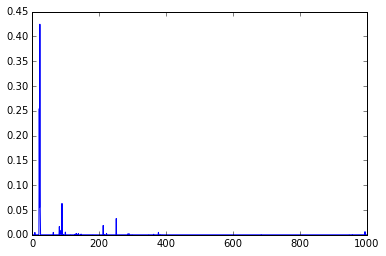

-----------------------------------------


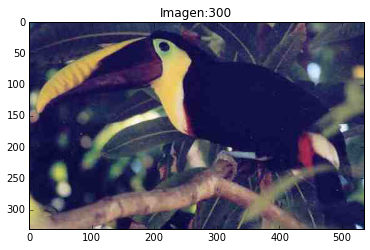

<IPython.core.display.Latex object>

,Prediccion
96,n01843383 toucan
392,"n02606052 rock beauty, Holocanthus tricolor"
93,n01829413 hornbill
416,"n02777292 balance beam, beam"
1,"n01443537 goldfish, Carassius auratus"
393,n02607072 anemone fish
71,n01770393 scorpion
433,"n02807133 bathing cap, swimming cap"
602,"n03535780 horizontal bar, high bar"
29,"n01632777 axolotl, mud puppy, Ambystoma mexicanum"


predicted class: 96


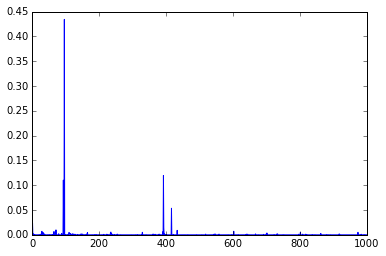

-----------------------------------------


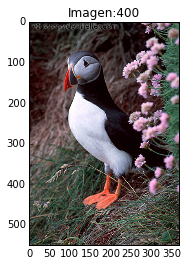

<IPython.core.display.Latex object>

,Prediccion
97,n01847000 drake
143,"n02037110 oystercatcher, oyster catcher"
99,n01855672 goose
18,n01582220 magpie
128,"n02002724 black stork, Ciconia nigra"
127,"n02002556 white stork, Ciconia ciconia"
146,"n02058221 albatross, mollymawk"
100,"n01860187 black swan, Cygnus atratus"
217,"n02102040 English springer, English springer s..."
86,n01807496 partridge


predicted class: 97


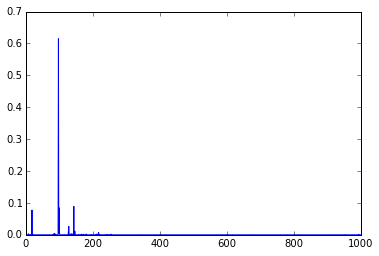

-----------------------------------------


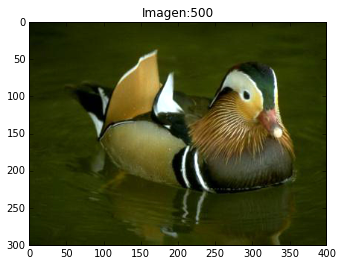

<IPython.core.display.Latex object>

,Prediccion
97,n01847000 drake
83,"n01798484 prairie chicken, prairie grouse, pra..."
11,"n01531178 goldfinch, Carduelis carduelis"
86,n01807496 partridge
134,n02012849 crane
99,n01855672 goose
144,n02051845 pelican
393,n02607072 anemone fish
117,"n01968897 chambered nautilus, pearly nautilus,..."
82,"n01797886 ruffed grouse, partridge, Bonasa umb..."


predicted class: 97


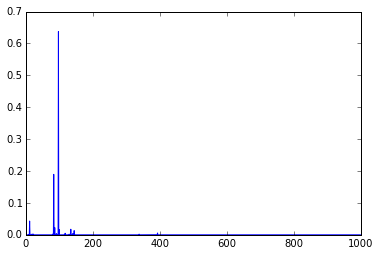

In [30]:
tam =  len(prediction)
sep = "-----------------------------------------"
for i in xrange( 0, tam, 100):
    print sep
    top_k =prediction[i].argsort()[-1:-11:-1]
    
    printImg(listPathImg[i], text="Imagen:"+str(i))
    
    table = pd.DataFrame( data=labels[top_k], columns=["Prediccion"], index=top_k )
    printTable( table, "Tabla Predicciones Imagen:"+str(i), latex=1)
    
    
    plt.plot(prediction[i])
    print 'predicted class:', prediction[i].argmax()
    plt.show()

In [31]:
# GPU mode
caffe.set_device(0)
caffe.set_mode_gpu()
out = net2.forward()  # call once for allocation
%timeit net2.forward()

100 loops, best of 3: 7.43 ms per loop


In [32]:
freq = np.sum(prediction, axis=0)
most_freq = freq.argsort()[-1:-11:-1]
most_freq_freq = freq[ most_freq ]

indice = {}
for idx, frq in enumerate( most_freq ):
    indice[frq] = idx
    
toTable = zip( most_freq, most_freq_freq, labels[ most_freq ] )
table = pd.DataFrame( data=toTable, index=range(1,len(most_freq)+1), columns=["ClaseID", "Peso", "Clase"])
printTable( table, "10 Mejores Datos", latex=0)

,ClaseID,Peso,Clase
1,97,132.449829,n01847000 drake
2,96,100.183464,n01843383 toucan
3,132,73.960930,"n02009912 American egret, great white heron, E..."
4,99,19.045040,n01855672 goose
5,81,16.627512,n01796340 ptarmigan
6,146,11.506304,"n02058221 albatross, mollymawk"
7,87,10.722032,"n01817953 African grey, African gray, Psittacu..."
8,143,10.414215,"n02037110 oystercatcher, oyster catcher"
9,129,9.063873,n02006656 spoonbill
10,21,9.011273,n01608432 kite


In [33]:
noIn = 10

confMatriz = np.zeros( (6, 11) )
idx = 0
for cnt, p in enumerate( prediction ):
    if( cnt!=0 and cnt%100==0 ):
        idx+=1; 
    #print cnt, p.argmax(), idx
    if p.argmax() in most_freq:
        confMatriz[idx][ indice[p.argmax()] ] +=1
    else:
        confMatriz[idx][ noIn ] +=1

In [34]:
col = [x for x in most_freq]
col.append('Otro')
table = pd.DataFrame(data=confMatriz, index=clase, columns=col)
printTable(table, "Matriz de Confusion para las 10 clases mas frecuentes", latex=0)

,97,96,132,99,81,146,87,143,129,21,Otro
wood_duck,87,0,0,0,0,0,0,1,0,0,12
egret,0,0,86,0,0,1,0,0,5,0,8
owl,0,0,0,1,23,0,15,0,0,9,52
toucan,0,97,0,0,0,0,0,0,0,0,3
puffin,9,11,0,22,2,12,0,13,0,0,31
mandarin,73,1,0,0,0,0,0,1,1,0,24


In [35]:
col = [labels[x] for x in most_freq]
col.append('Otro')
table = pd.DataFrame(data=confMatriz, index=clase, columns=col)
printTable(table, "Matriz de Confusion para las 10 clases mas frecuentes(Label)", latex=0)

,n01847000 drake,n01843383 toucan,"n02009912 American egret, great white heron, Egretta albus",n01855672 goose,n01796340 ptarmigan,"n02058221 albatross, mollymawk","n01817953 African grey, African gray, Psittacus erithacus","n02037110 oystercatcher, oyster catcher",n02006656 spoonbill,n01608432 kite,Otro
wood_duck,87,0,0,0,0,0,0,1,0,0,12
egret,0,0,86,0,0,1,0,0,5,0,8
owl,0,0,0,1,23,0,15,0,0,9,52
toucan,0,97,0,0,0,0,0,0,0,0,3
puffin,9,11,0,22,2,12,0,13,0,0,31
mandarin,73,1,0,0,0,0,0,1,1,0,24


In [36]:
def printFreqByRange( ii, low, high, msg="10 Datos mas frecuentes"):
    freq2 = np.sum(prediction[low:high], axis=0)
    most_freq2 = freq2.argsort()[-1:-11:-1]
    most_freq_freq2 = freq2[ most_freq ]
    
    indice2 = {}
    for idx, frq in enumerate( most_freq2 ):
        indice2[frq] = idx
    
    toTable = zip( most_freq2, most_freq_freq2, labels[ most_freq2 ] )
    table = pd.DataFrame( data=toTable, index=range(1,len(most_freq2)+1), columns=["ClaseID", "Peso", "Clase"])
    printTable( table, msg, latex=0)
    
    noIn = 10

    confMatriz = np.zeros( 11 )
    for cnt, p in enumerate( prediction[low:high] ):
        if p.argmax() in most_freq2:
            confMatriz[ indice2[p.argmax()] ] +=1
        else:
            confMatriz[ noIn ] +=1
    
    
    col = [x for x in most_freq2]
    col.append('Otro')
    #table = pd.DataFrame(data=confMatriz, index=[clase[ii]], columns=col)
    table = pd.DataFrame(data=confMatriz, index=col, columns=[clase[ii]])
    printTable(table.T, "Matriz de Confusion para: "+msg, latex=0)
    
    col = [labels[x] for x in most_freq2]
    col.append('Otro')
    table = pd.DataFrame(data=confMatriz, index=col, columns=[clase[ii]])
    printTable(table.T, "Matriz de Confusion para: "+msg, latex=0)

In [37]:
for i in xrange(5):
    print sep, i, sep
    printFreqByRange(i, i*100, (i+1)*100, msg="10 mejores datos de "+clase[i])

----------------------------------------- 0 -----------------------------------------


,ClaseID,Peso,Clase
1,97,69.366783,n01847000 drake
2,98,1.132349,"n01855032 red-breasted merganser, Mergus serrator"
3,85,0.009414,n01806567 quail
4,80,0.545437,n01795545 black grouse
5,96,0.016898,n01843383 toucan
6,306,0.030528,n02174001 rhinoceros beetle
7,86,0.002376,n01807496 partridge
8,93,0.489185,n01829413 hornbill
9,145,0.053941,"n02056570 king penguin, Aptenodytes patagonica"
10,836,0.021270,n04355933 sunglass


,97,98,85,80,96,306,86,93,145,836,Otro
wood_duck,87,3,2,2,0,1,0,1,1,0,3


,n01847000 drake,"n01855032 red-breasted merganser, Mergus serrator",n01806567 quail,n01795545 black grouse,n01843383 toucan,n02174001 rhinoceros beetle,n01807496 partridge,n01829413 hornbill,"n02056570 king penguin, Aptenodytes patagonica",n04355933 sunglass,Otro
wood_duck,87,3,2,2,0,1,0,1,1,0,3


----------------------------------------- 1 -----------------------------------------


,ClaseID,Peso,Clase
1,132,0.015723,"n02009912 American egret, great white heron, E..."
2,129,0.008827,n02006656 spoonbill
3,131,73.492348,"n02009229 little blue heron, Egretta caerulea"
4,134,0.365361,n02012849 crane
5,146,0.359773,"n02058221 albatross, mollymawk"
6,149,1.202362,"n02074367 dugong, Dugong dugon"
7,89,0.005909,"n01819313 sulphur-crested cockatoo, Kakatoe ga..."
8,144,0.012972,n02051845 pelican
9,127,7.770277,"n02002556 white stork, Ciconia ciconia"
10,99,0.063557,n01855672 goose


,132,129,131,134,146,149,89,144,127,99,Otro
egret,86,5,2,1,1,1,0,0,1,0,3


,"n02009912 American egret, great white heron, Egretta albus",n02006656 spoonbill,"n02009229 little blue heron, Egretta caerulea",n02012849 crane,"n02058221 albatross, mollymawk","n02074367 dugong, Dugong dugon","n01819313 sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita",n02051845 pelican,"n02002556 white stork, Ciconia ciconia",n01855672 goose,Otro
egret,86,5,2,1,1,1,0,0,1,0,3


----------------------------------------- 2 -----------------------------------------


,ClaseID,Peso,Clase
1,81,0.099735,n01796340 ptarmigan
2,87,0.003869,"n01817953 African grey, African gray, Psittacu..."
3,21,0.119527,n01608432 kite
4,89,1.933431,"n01819313 sulphur-crested cockatoo, Kakatoe ga..."
5,24,14.923244,"n01622779 great grey owl, great gray owl, Stri..."
6,63,0.582524,"n01748264 Indian cobra, Naja naja"
7,85,10.135684,n01806567 quail
8,83,0.001715,"n01798484 prairie chicken, prairie grouse, pra..."
9,22,0.114039,"n01614925 bald eagle, American eagle, Haliaeet..."
10,82,7.207903,"n01797886 ruffed grouse, partridge, Bonasa umb..."


,81,87,21,89,24,63,85,83,22,82,Otro
owl,23,15,9,4,7,7,5,3,2,2,23


,n01796340 ptarmigan,"n01817953 African grey, African gray, Psittacus erithacus",n01608432 kite,"n01819313 sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita","n01622779 great grey owl, great gray owl, Strix nebulosa","n01748264 Indian cobra, Naja naja",n01806567 quail,"n01798484 prairie chicken, prairie grouse, prairie fowl","n01614925 bald eagle, American eagle, Haliaeetus leucocephalus","n01797886 ruffed grouse, partridge, Bonasa umbellus",Otro
owl,23,15,9,4,7,7,5,3,2,2,23


----------------------------------------- 3 -----------------------------------------


,ClaseID,Peso,Clase
1,96,0.036704,n01843383 toucan
2,93,90.653397,n01829413 hornbill
3,22,0.008289,"n01614925 bald eagle, American eagle, Haliaeet..."
4,88,0.008622,n01818515 macaw
5,145,0.000227,"n02056570 king penguin, Aptenodytes patagonica"
6,723,0.021993,n03944341 pinwheel
7,392,0.032665,"n02606052 rock beauty, Holocanthus tricolor"
8,377,0.020550,n02490219 marmoset
9,306,0.003401,n02174001 rhinoceros beetle
10,380,0.074863,"n02493509 titi, titi monkey"


,96,93,22,88,145,723,392,377,306,380,Otro
toucan,97,2,1,0,0,0,0,0,0,0,0


,n01843383 toucan,n01829413 hornbill,"n01614925 bald eagle, American eagle, Haliaeetus leucocephalus",n01818515 macaw,"n02056570 king penguin, Aptenodytes patagonica",n03944341 pinwheel,"n02606052 rock beauty, Holocanthus tricolor",n02490219 marmoset,n02174001 rhinoceros beetle,"n02493509 titi, titi monkey",Otro
toucan,97,2,1,0,0,0,0,0,0,0,0


----------------------------------------- 4 -----------------------------------------


,ClaseID,Peso,Clase
1,99,7.443532,n01855672 goose
2,146,7.570428,"n02058221 albatross, mollymawk"
3,143,0.252344,"n02037110 oystercatcher, oyster catcher"
4,96,14.239087,n01843383 toucan
5,97,1.306067,n01847000 drake
6,80,9.565652,n01795545 black grouse
7,128,0.538271,"n02002724 black stork, Ciconia nigra"
8,22,9.453603,"n01614925 bald eagle, American eagle, Haliaeet..."
9,18,0.206869,n01582220 magpie
10,86,1.555068,n01807496 partridge


,99,146,143,96,97,80,128,22,18,86,Otro
puffin,22,12,13,11,9,6,3,3,1,2,18


,n01855672 goose,"n02058221 albatross, mollymawk","n02037110 oystercatcher, oyster catcher",n01843383 toucan,n01847000 drake,n01795545 black grouse,"n02002724 black stork, Ciconia nigra","n01614925 bald eagle, American eagle, Haliaeetus leucocephalus",n01582220 magpie,n01807496 partridge,Otro
puffin,22,12,13,11,9,6,3,3,1,2,18


La subclase Caffe.Classifier, presento un mejor desempeño que la clase Caffe.Net, se podria decir que el proceso adicional que se aplica, si da un valor agregado, lo malo es que esta clase solo almacena los datos de las ultimas 10 imagenes que ha predecido, por lo tanto no se podran usar esta clase para los siguientes puntos del taller.

### (C) Train a linear classifier, use the output of the 'fc6'

In [38]:
ls birds/

birds_f_numbers.txt       egret/     owl/     toucan/
birds_training_pairs.txt  mandarin/  puffin/  wood_duck/


In [39]:
!cat birds/birds_f_numbers.txt

%% File numbers for training/testing on the bird database.
%% The first 20 files in the list were used for training 
%% (see birds_training_pairs.txt for lists of training pairs), 
%% the next 30 for validation, and the final 50 for testing.
%% If your recognition approach does not have a separate 
%% validation phase, simply use the first 50 numbers for
%% training and the rest for testing.

Egret

    18
    75
    29
    57
    71
    22
    23
    20
    79
    53
    21
    97
    66
    95
    11
    32
    50
    42
    40
     9
    89
    91
    26
    62
    59
    48
    98
    44
    87
    93
    61
    39
    94
    14
    16
    52
    54
    43
     6
    36
    81
    38
     8
    56
    63
    12
    78
    99
    34
     3
    86
    41
    13
     4
    47
    45
    15
    67
    80
    35
    19
     7
    58
    72
    51
    31
    17
    27
    88
    10
   100
    84
     1
    74
    49
    68
    64
    96
    65
    76
    46
    85
    69
    37
    28
  

Parsear al archivo correcto

In [55]:
#mapeo axiliar para construir archivos de cada conjunto de datos
classToDim = {"wood_duck": "wod",
              "egret": "egr",
              "owl": "owl",
              "toucan": "tou",
              "puffin": "puf",
              "mandarin": "man" }

In [56]:
arch = open(data_root+'birds_f_numbers.txt')
lines = [line.strip().lower().replace(' ', '_') for line in arch.read().splitlines() if len(line)>0][7:]

In [57]:
def listToPathFile( nameClass, lista):
    path_list = []
    for num in lista:
        imagen ="%(root)s%(folder)s/%(prefijo)s%(id)03d.jpg" % {'root': data_root, 'folder': nameClass, 'prefijo': classToDim[nameClass],'id':int(num)}
        path_list.append( imagen )
    return path_list

Separar los datos en train, validate y test. El conjunto de datos de train contiene 20 imagenes y se utiliza para entrenar lar ed, en validate se consideraron 30 imaganes utilizadas para encontrar los parametos adecuados y el conjunto de test con las 50 imagenes restantes se utilizo para probar los modelos.

In [58]:
listTrain = []
listValidate = []
listTest = []

for idx in xrange(0,600, 101):
    aux = listToPathFile( lines[idx], lines[idx+1:idx+101])
    listTrain.extend( aux[0:20] )
    listValidate.extend( aux[20:50] )
    listTest.extend( aux[50:100] )
    

Obteniendo los datos de las capas fc6 y fc7


In [61]:
#Coreccion al predict_images_layers, para corregir los problemas de actualizacion
def predict_images_layers2( paths ):
    prediction = []
    fc6 = []
    fc7 = []
    
    for idx, img in enumerate( paths ):
        prediction.append( net.blobs['prob'].data[ pathToIdx[img] ].flatten() )
        fc6.append( np.copy(net.blobs['fc6'].data[ pathToIdx[img] ]) )
        fc7.append( np.copy(net.blobs['fc7'].data[ pathToIdx[img] ]) )
    return prediction, fc6, fc7

In [62]:
train_pred, train_fc6, train_fc7 = predict_images_layers2( listTrain )
vali_pred, vali_fc6, vali_fc7 = predict_images_layers2( listValidate )
test_pred, test_fc6, test_fc7 = predict_images_layers2( listTest )

In [63]:
len(train_fc6[0])

4096

In [64]:
print train_pred[0][:3], sum(train_fc6[0]), train_pred[0].argmax()
print vali_pred[0][:3], sum(vali_fc6[0]), vali_pred[0].argmax()
print test_pred[0][:3], sum(test_fc6[0]), test_pred[0].argmax()

[  5.03601084e-11   1.62017164e-10   6.26892427e-11] 6411.53273923 132
[  7.85129657e-07   1.30753968e-08   1.29846539e-05] 3976.86480829 132
[  9.78548906e-06   1.40513614e-04   2.81921530e-04] 5740.89569945 388


n02009912 American egret, great white heron, Egretta albus


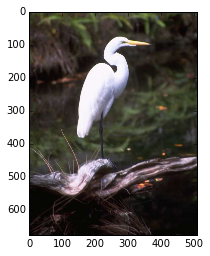

n02009912 American egret, great white heron, Egretta albus


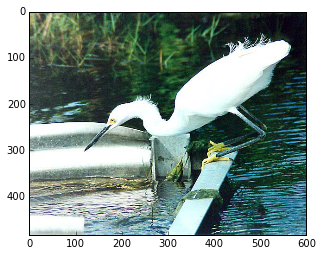

n02510455 giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca


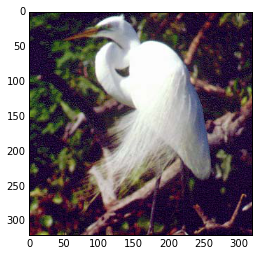

In [67]:
print labels[ train_pred[0].argmax() ]
printImg( listTrain[0] )
print labels[ vali_pred[0].argmax() ]
printImg( listValidate[0] )
print labels[ test_pred[0].argmax() ]
printImg( listTest[0] )


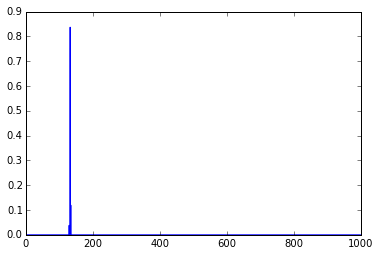

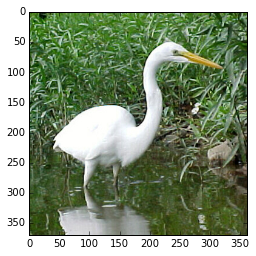

n02009912 American egret, great white heron, Egretta albus


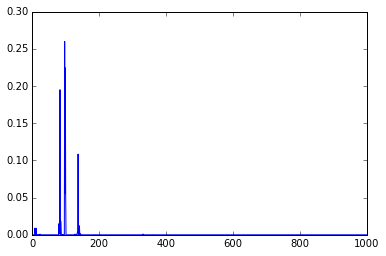

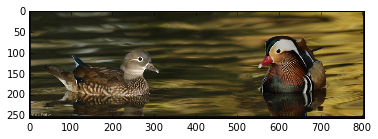

n01847000 drake


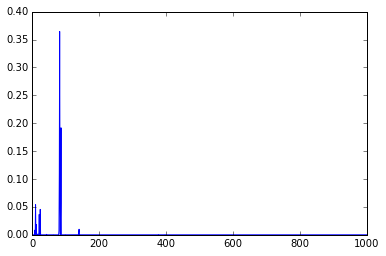

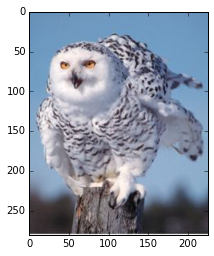

n01797886 ruffed grouse, partridge, Bonasa umbellus


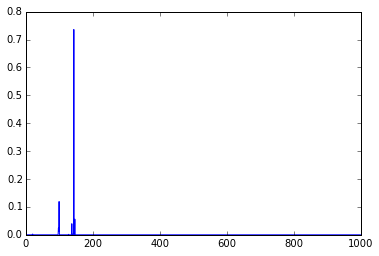

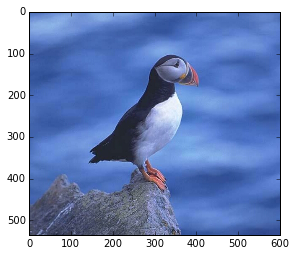

n02037110 oystercatcher, oyster catcher


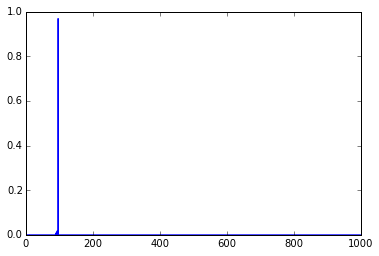

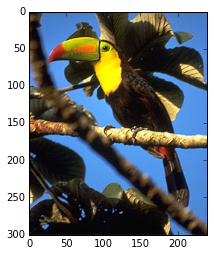

n01843383 toucan


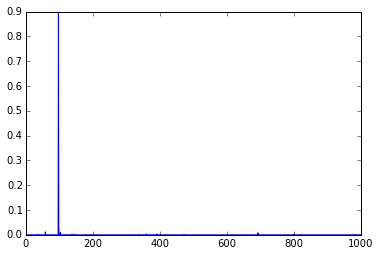

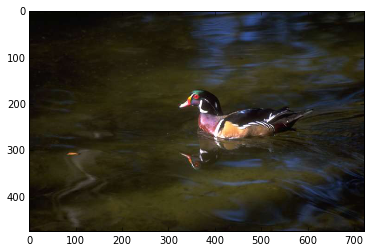

n01847000 drake


In [69]:

for idx in xrange( 1, len(listTrain), 20 ):
    auxPred = predict_image( listTrain[idx] )
    #print len( auxPred. )
    plt.show()
    plt.plot( train_pred[idx] )
    plt.show()
    printImg( listTrain[idx] )
    print labels[train_pred[idx].argmax()]

Los datos y clases ordenados en el orden de "birds/birds_f_numbers.txt" serian:
* Egret
* Mandarin
* Owl
* Puffin
* Tucan
* Wood duck

In [70]:
classNames = ["Egret", "Mandarin", "Owl", "Puffin", "Tucan", "Wood duck"]

In [71]:
tam = 20
labels_train = ["Egret"]*tam+["Mandarin"]*tam+["Owl"]*tam+["Puffin"]*tam \
+["Tucan"]*tam+["Wood duck"]*tam
tam = 30
labels_vali = ["Egret"]*tam+["Mandarin"]*tam+["Owl"]*tam+["Puffin"]*tam \
+["Tucan"]*tam+["Wood duck"]*tam
tam = 50
labels_test = ["Egret"]*tam+["Mandarin"]*tam+["Owl"]*tam+["Puffin"]*tam \
+["Tucan"]*tam+["Wood duck"]*tam

Realizando la clasificacion:

In [72]:
from sklearn import svm
from sklearn.linear_model import LogisticRegression

In [73]:
LINEAL = "Lineal"
SVC = "SVC"
LOG_REG = "Log Reg"

def calcularError( prediccion, valReal):
    pred = prediccion
    vals = valReal
    dif = [ idx for idx in xrange( len(vals) ) if pred[idx]!=vals[idx] ]
    return len(dif)*1.0/len(valReal)

In [108]:
def clasificarValidacion( train, labels, valid, labelsValid, c=1, typeClf=LINEAL):
    if typeClf==LINEAL:
        clf = svm.LinearSVC( C=c )
    elif typeClf==SVC:    
        clf = svm.SVC( C=c )
    else:
        clf = LogisticRegression( C=c )
        
    clf.fit( train, labels)
    sol = clf.predict( valid )
    #dif = [ idx for idx in xrange( len(sol) ) if labelsValid[idx]!=sol[idx] ]
    
    return clf.score(valid, labelsValid), sol

Evaluate the data set in the **fc6** layer whit validation partition to find a optimal parameters

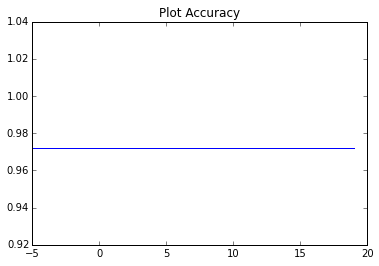

,0,22,21,20,19,18,17,16,15,14,...,8,7,6,5,4,3,2,1,11,24
Score,0.972222,0.972222,0.972222,0.972222,0.972222,0.972222,0.972222,0.972222,0.972222,0.972222,...,0.972222,0.972222,0.972222,0.972222,0.972222,0.972222,0.972222,0.972222,0.972222,0.972222


Mejor C= 1


Predicted,Egret,Mandarin,Owl,Puffin,Tucan,Wood duck
Actual,,,,,,
Egret,30,0,0,0,0,0
Mandarin,0,27,0,1,0,2
Owl,0,0,30,0,0,0
Puffin,0,0,0,29,0,1
Tucan,0,0,0,0,29,1
Wood duck,0,0,0,0,0,30


In [131]:
msg = "Evaluando con los datos del conjunto de validacion para la capa fc6 usando SVM Lineal"
display(HTML('<center><b><font color="red">'+msg+'</font></b></center>') )
score = []
for pot in xrange(-5, 20):
    sc,data= clasificarValidacion( train_fc6, labels_train, vali_fc6, labels_vali, c=2.0**pot, typeClf=LINEAL)
    score.append(sc)

score = np.array(score)
table = pd.DataFrame(data=score[ score.argsort() ] , index= score.argsort(), columns=["Score"])
plt.plot(range(-5,20), score)
plt.title("Plot Accuracy")
plt.show()
printTable( table.T, "Accuracy", latex=0)
print "Mejor C=",2**score.argmax()
sc, data = clasificarValidacion( train_fc6, labels_train, vali_fc6, labels_vali, c=2.0**score.argmax(), typeClf=LINEAL)
data = np.array( data, dtype=object)
data2= np.array( labels_vali, dtype=object)
table = pd.crosstab(data2, data, rownames=["Actual"], colnames=["Predicted"])
printTable(table, "Matriz de confusion fc6" , latex=0)

De las datos anteriores podemos ver que no interesa la constante ( de las que se usaron ) se cuando se aplica un SVM Lineal asi que procederemos a evaluar los datos de test con cualquier valor de C

In [134]:
msg = "Evaluando con los datos del conjunto de Test para la capa fc6 usando SVM Lineal"
display(HTML('<center><b><font color="red">'+msg+'</font></b></center>') )


sc, data = clasificarValidacion( train_fc6, labels_train, test_fc6, labels_test, c=1, typeClf=LINEAL)
print "El accuracy de clasificar: ", sc

data = np.array( data, dtype=object)
data2= np.array( labels_test, dtype=object)
table = pd.crosstab(data2, data, rownames=["Actual"], colnames=["Predicted"])
printTable(table, "Matriz de confusion fc6 datos test" , latex=0)



El accuracy de clasificar:  0.966666666667


Predicted,Egret,Mandarin,Owl,Puffin,Tucan,Wood duck
Actual,,,,,,
Egret,49,0,0,1,0,0
Mandarin,0,44,0,5,0,1
Owl,0,0,50,0,0,0
Puffin,0,0,0,50,0,0
Tucan,0,0,0,0,49,1
Wood duck,0,1,0,1,0,48


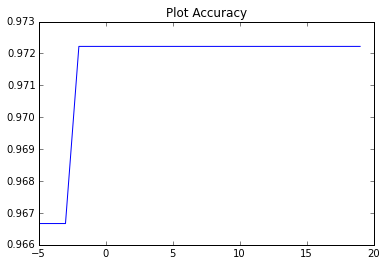

,0,1,2,22,21,20,19,18,17,16,...,10,9,8,7,6,5,4,3,23,24
Score,0.966667,0.966667,0.966667,0.972222,0.972222,0.972222,0.972222,0.972222,0.972222,0.972222,...,0.972222,0.972222,0.972222,0.972222,0.972222,0.972222,0.972222,0.972222,0.972222,0.972222


Mejor C= 8


Predicted,Egret,Mandarin,Owl,Puffin,Tucan,Wood duck
Actual,,,,,,
Egret,30,0,0,0,0,0
Mandarin,0,28,0,1,0,1
Owl,0,0,30,0,0,0
Puffin,0,0,1,28,0,1
Tucan,0,0,0,0,29,1
Wood duck,0,0,0,0,0,30


In [136]:
msg = "Evaluando con los datos del conjunto de validacion para la capa fc6 usando Logistic Regression "
display(HTML('<center><b><font color="red">'+msg+'</font></b></center>') )
score = []
for pot in xrange(-5, 20):
    sc,data= clasificarValidacion( train_fc6, labels_train, vali_fc6, labels_vali, c=2.0**pot, typeClf=LOG_REG)
    score.append(sc)

score = np.array(score)
table = pd.DataFrame(data=score[ score.argsort() ] , index= score.argsort(), columns=["Score"])
plt.plot(range(-5,20), score)
plt.title("Plot Accuracy")
plt.show()
printTable( table.T, "Accuracy", latex=0)
print "Mejor C=",2**score.argmax()
sc, data = clasificarValidacion( train_fc6, labels_train, vali_fc6, labels_vali, c=2.0**score.argmax(), typeClf=LOG_REG)
data = np.array( data, dtype=object)
data2= np.array( labels_vali, dtype=object)
table = pd.crosstab(data2, data, rownames=["Actual"], colnames=["Predicted"])
printTable(table, "Matriz de confusion fc6" , latex=0)


De las datos anteriores podemos ver que la mejor constante **C** se cuando se aplica un Logistic Regression es cuando **C=$2^3$=8** asi que se procede a evaluar los conjuntos de testo con **C=8**

In [137]:
msg = "Evaluando con los datos del conjunto de Test para la capa fc6 usando Logistic Regresion"
display(HTML('<center><b><font color="red">'+msg+'</font></b></center>') )


sc, data = clasificarValidacion( train_fc6, labels_train, test_fc6, labels_test, c=8, typeClf=LOG_REG)
print "El accuracy de clasificar: ", sc

data = np.array( data, dtype=object)
data2= np.array( labels_test, dtype=object)
table = pd.crosstab(data2, data, rownames=["Actual"], colnames=["Predicted"])
printTable(table, "Matriz de confusion fc6 datos test" , latex=0)



El accuracy de clasificar:  0.973333333333


Predicted,Egret,Mandarin,Owl,Puffin,Tucan,Wood duck
Actual,,,,,,
Egret,50,0,0,0,0,0
Mandarin,0,45,0,4,0,1
Owl,0,0,50,0,0,0
Puffin,0,0,0,50,0,0
Tucan,0,0,0,0,49,1
Wood duck,0,1,0,1,0,48


### D) Repeat the previous step, but using features of the **fc7** layer

Evaluate the data set in the **fc7** layer whit validation partition to find a optimal parameters

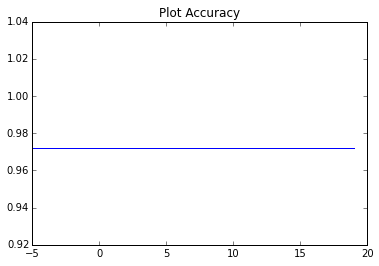

,0,22,21,20,19,18,17,16,15,14,...,8,7,6,5,4,3,2,1,11,24
Score,0.972222,0.972222,0.972222,0.972222,0.972222,0.972222,0.972222,0.972222,0.972222,0.972222,...,0.972222,0.972222,0.972222,0.972222,0.972222,0.972222,0.972222,0.972222,0.972222,0.972222


Mejor C= 1


Predicted,Egret,Mandarin,Owl,Puffin,Tucan,Wood duck
Actual,,,,,,
Egret,30,0,0,0,0,0
Mandarin,0,28,0,1,0,1
Owl,0,0,30,0,0,0
Puffin,0,0,0,29,1,0
Tucan,0,0,0,0,29,1
Wood duck,0,1,0,0,0,29


In [138]:
msg = "Evaluando con los datos del conjunto de validacion para la capa fc7 usando SVM Lineal"
display(HTML('<center><b><font color="red">'+msg+'</font></b></center>') )
score = []
for pot in xrange(-5, 20):
    sc,data= clasificarValidacion( train_fc7, labels_train, vali_fc7, labels_vali, c=2.0**pot, typeClf=LINEAL)
    score.append(sc)

score = np.array(score)
table = pd.DataFrame(data=score[ score.argsort() ] , index= score.argsort(), columns=["Score"])
plt.plot(range(-5,20), score)
plt.title("Plot Accuracy")
plt.show()
printTable( table.T, "Accuracy", latex=0)
print "Mejor C=",2**score.argmax()
sc, data = clasificarValidacion( train_fc7, labels_train, vali_fc7, labels_vali, c=2.0**score.argmax(), typeClf=LINEAL)
data = np.array( data, dtype=object)
data2= np.array( labels_vali, dtype=object)
table = pd.crosstab(data2, data, rownames=["Actual"], colnames=["Predicted"])
printTable(table, "Matriz de confusion fc6" , latex=0)


In [140]:
msg = "Evaluando con los datos del conjunto de Test para la capa fc7 usando SVM Lineal"
display(HTML('<center><b><font color="red">'+msg+'</font></b></center>') )


sc, data = clasificarValidacion( train_fc7, labels_train, test_fc7, labels_test, c=1, typeClf=LINEAL)
print "El accuracy de clasificar: ", sc

data = np.array( data, dtype=object)
data2= np.array( labels_test, dtype=object)
table = pd.crosstab(data2, data, rownames=["Actual"], colnames=["Predicted"])
printTable(table, "Matriz de confusion fc7 datos test" , latex=0)


El accuracy de clasificar:  0.966666666667


Predicted,Egret,Mandarin,Owl,Puffin,Tucan,Wood duck
Actual,,,,,,
Egret,50,0,0,0,0,0
Mandarin,0,42,0,5,1,2
Owl,0,0,50,0,0,0
Puffin,0,0,0,50,0,0
Tucan,0,0,0,0,50,0
Wood duck,0,1,0,1,0,48


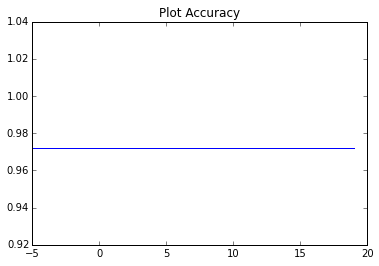

,0,22,21,20,19,18,17,16,15,14,...,8,7,6,5,4,3,2,1,11,24
Score,0.972222,0.972222,0.972222,0.972222,0.972222,0.972222,0.972222,0.972222,0.972222,0.972222,...,0.972222,0.972222,0.972222,0.972222,0.972222,0.972222,0.972222,0.972222,0.972222,0.972222


Mejor C= 1


Predicted,Egret,Mandarin,Owl,Puffin,Tucan,Wood duck
Actual,,,,,,
Egret,30,0,0,0,0,0
Mandarin,0,28,0,1,0,1
Owl,0,0,30,0,0,0
Puffin,0,0,0,29,1,0
Tucan,0,0,0,0,29,1
Wood duck,0,1,0,0,0,29


In [141]:
msg = "Evaluando con los datos del conjunto de validacion para la capa fc7 usando Logistic Regression "
display(HTML('<center><b><font color="red">'+msg+'</font></b></center>') )
score = []
for pot in xrange(-5, 20):
    sc,data= clasificarValidacion( train_fc7, labels_train, vali_fc7, labels_vali, c=2.0**pot, typeClf=LOG_REG)
    score.append(sc)

score = np.array(score)
table = pd.DataFrame(data=score[ score.argsort() ] , index= score.argsort(), columns=["Score"])
plt.plot(range(-5,20), score)
plt.title("Plot Accuracy")
plt.show()
printTable( table.T, "Accuracy", latex=0)
print "Mejor C=",2**score.argmax()
sc, data = clasificarValidacion( train_fc7, labels_train, vali_fc7, labels_vali, c=2.0**score.argmax(), typeClf=LOG_REG)
data = np.array( data, dtype=object)
data2= np.array( labels_vali, dtype=object)
table = pd.crosstab(data2, data, rownames=["Actual"], colnames=["Predicted"])
printTable(table, "Matriz de confusion fc7" , latex=0)

In [142]:
msg = "Evaluando con los datos del conjunto de Test para la capa fc7 usando Logistic Regresion"
display(HTML('<center><b><font color="red">'+msg+'</font></b></center>') )


sc, data = clasificarValidacion( train_fc7, labels_train, test_fc7, labels_test, c=1, typeClf=LOG_REG)
print "El accuracy de clasificar: ", sc

data = np.array( data, dtype=object)
data2= np.array( labels_test, dtype=object)
table = pd.crosstab(data2, data, rownames=["Actual"], colnames=["Predicted"])
printTable(table, "Matriz de confusion fc7 datos test" , latex=0)


El accuracy de clasificar:  0.966666666667


Predicted,Egret,Mandarin,Owl,Puffin,Tucan,Wood duck
Actual,,,,,,
Egret,50,0,0,0,0,0
Mandarin,0,42,0,5,1,2
Owl,0,0,50,0,0,0
Puffin,0,0,0,50,0,0
Tucan,0,0,0,0,50,0
Wood duck,0,1,0,1,0,48


##Conclusiones

En general los resultados del accuracy en la clasificacion para la capa 7 fueron mejores que que para los de la capa 6 en ambos modelos. 

En ambas capas y con todos los clasificadores el ave mejor clasificada fue el Egret, creemos que es porque de todas es la que tiene la fisionomia mas diferente, la peor clasificada siempre fue el mandarin, muchas  veces fue clasificado como un Puffin o como un Pato.

**fc6 SVM Lineal:** 0.966666666667
**fc6 LG:** 0.973333333333
    
**fc7 SVM Lineal:** 0.966666666667
**fc7 LG:** 0.966666666667

## ------------------------------------